# Speech2Text

## Articles:
* QuartzNet: Deep Automatic Speech Recognition with 1D Time-Channel Separable Convolutions: https://arxiv.org/abs/1910.10261
* ContextNet: Improving Convolutional Neural Networks for Automatic Speech Recognition with Global Context: https://arxiv.org/abs/2005.03191 
* Conformer: Convolution-augmented Transformer for Speech Recognition: https://arxiv.org/abs/2005.08100 
* Speech2Text overview: https://thegradient.pub/towards-an-imagenet-moment-for-speech-to-text/#open-speech-to-text-russian- 


## Dataset:
Source: https://www.openslr.org/12/
* train set, "clean" speech
* development set, "clean" speech
* development set, "other", more challenging, speech
* test set, "clean" speech
* test set, "other" speech

## Requirements:
* python==3.8.10
* torch==1.10.2

In [1]:
import torch
import torch.nn.functional as F
import torchaudio
from glob import glob

## Preprocessing

### Manual

In [2]:
TRAIN_CLEAN_PATH = r"LibriSpeech/train-clean-100/data/"
TEST_CLEAN_PATH = r"LibriSpeech/test-clean/data/"
TEST_OTHER_PATH = r"LibriSpeech/test-other/data/"
DEV_CLEAN_PATH = r"LibriSpeech/dev-clean/data/"
DEV_OTHER_PATH = r"LibriSpeech/dev-other/data/"

In [17]:
def samples_paths(set_path, limits=-1):
    samples = glob(set_path + '**/*.flac', recursive=True)[:limits]

    return map(
        lambda x: (torchaudio.load(x)[0], x.split('/')[-1].split('.')[0]), 
        samples
    )

In [18]:
def samples_labels(set_path):
    labels_path = glob(set_path + '**/*.trans.txt', recursive=True)

    labels = dict()
    for label in labels_path:
        with open(label, 'r') as fout:
            for line in fout:
                items = line.split()
                labels[items[0]] = ' '.join(items[1:])
    
    return labels

In [5]:
#TRAIN_CLEAN_SAMPLES = samples_paths(TRAIN_CLEAN_PATH)
TEST_CLEAN_SAMPLES = samples_paths(TEST_CLEAN_PATH)
TEST_OTHER_SAMPLES = samples_paths(TEST_OTHER_PATH)
DEV_CLEAN_SAMPLES = samples_paths(DEV_CLEAN_PATH)
DEV_OTHER_SAMPLES = samples_paths(DEV_OTHER_PATH)

In [19]:
def gen_tensor_set(set_path, limits=-1):
    """
    Function to group data with their labels within dataset.  

    :params set_path: the whole path to the data folder.
    :returns: dict:
        * samples: tensor of all the loaded audiodata within dataset; 
        * labels: list of all text corresponding to the audio; 
        * mask: to identify the end of the signal.
    """
    
    # Loading data in format (np.array of signal, text_id) -> list.  
    samples = list(samples_paths(set_path, limits))
    # Loading data in format {text_id: text} -> dict.  
    labels = samples_labels(set_path)

    # Signals in list form to represent them as a tensor with paddings.  
    signals = [s[0] for s, _ in samples]
    labels = [labels[l] for _, l in samples]
    
    signal_lengths = [len(s) for s in signals]
    max_length = max(signal_lengths)
    tail_to_pad = [max_length - l for l in signal_lengths]

    padded_set = torch.vstack([
        F.pad(x, pad=(0, l))
        for x, l in zip(signals, tail_to_pad)
    ])
    mask = torch.zeros((len(samples), max_length))

    for row in range(len(samples)):
        mask[row, :tail_to_pad[row]] = 1

    return {
        'samples': padded_set, 
        'labels': labels, 
        'mask': mask.type(torch.bool)
    }

In [20]:
result = gen_tensor_set(TEST_CLEAN_PATH, limits=50)

In [22]:
result['samples']

tensor([[ 7.6294e-04,  2.8381e-03, -3.9062e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-6.4087e-04, -2.7466e-04,  1.5259e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 4.5776e-04,  5.4932e-04, -1.8311e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-5.4932e-04, -7.0190e-04, -2.1362e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-9.4604e-04, -8.5449e-04, -5.7983e-04,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.5259e-04,  3.3569e-04,  9.1553e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])

### torch.datasets.LIBRISPEECH

In [ ]:
d = torchaudio.datasets.LIBRISPEECH("LibriSpeech/", url='dev-clean')

## Analysis

In [5]:
sample_path = 'LibriSpeech/dev-clean/1462/170138/1462-170138-0000.flac'
label = "HE HAD WRITTEN A NUMBER OF BOOKS HIMSELF AMONG THEM A HISTORY OF DANCING A HISTORY OF COSTUME A KEY TO SHAKESPEARE'S SONNETS A STUDY OF THE POETRY OF ERNEST DOWSON ET CETERA"
sample, sample_rate = torchaudio.load(sample_path)

In [6]:
from IPython.display import display, Audio

In [9]:
display(Audio(sample_path, rate=sample_rate))

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

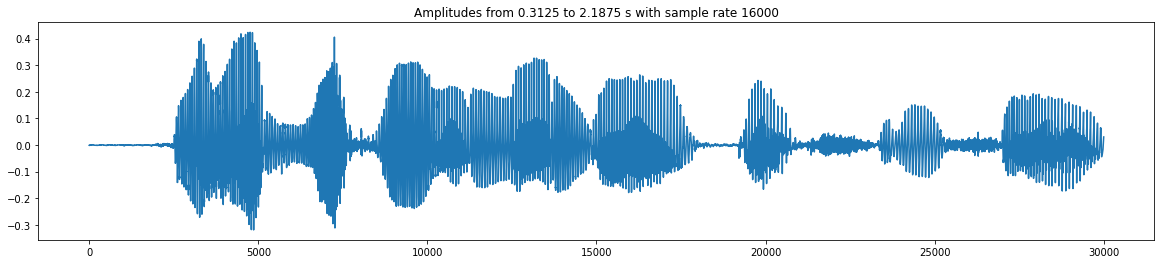

In [31]:
FROM, TO = 5000, 35000

plt.figure(figsize=(20, 4))
plt.title(f'Amplitudes from {FROM/sample_rate} to {TO/sample_rate} s with sample rate {sample_rate}')
plt.plot(sample[0, FROM:TO])
plt.show()

In [205]:
def slice_fragments(signal, window_size, overlap=512):
    val_to_pad = window_size - \
                (len(signal) + overlap) % window_size
    max_idx = (len(signal) + overlap + val_to_pad) // ws
    
    signal = F.pad(signal, pad=(0, val_to_pad), value=0)
    
    # First window.  
    parted = signal[:window_size].unsqueeze(0)
    # From second to the end.  
    rest_stack = torch.vstack([
        signal[i*window_size-overlap:(i+1)*window_size-overlap] \
            for i in range(1, max_idx)
    ])
    
    return torch.vstack((parted, rest_stack))

In [231]:
ws = 1024
overlap = 512

In [232]:
dummy_frames = slice_fragments(sample[0], ws, overlap)

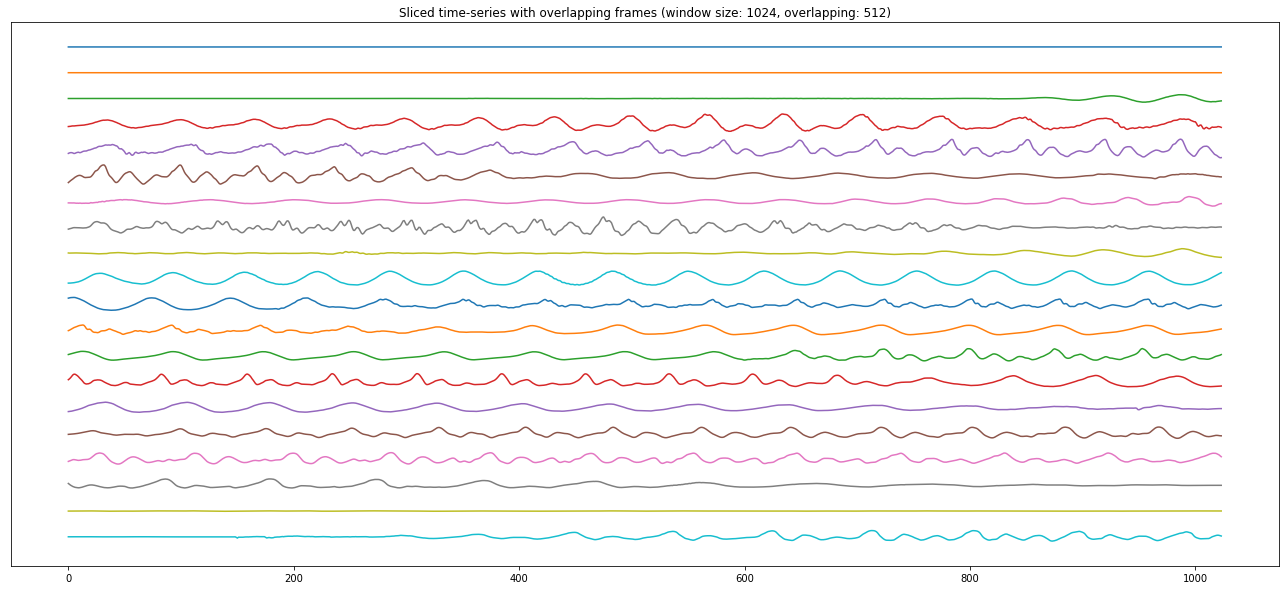

In [235]:
plt.figure(figsize=(50, 10))
plt.subplot(122, title=f'Sliced time-series with overlapping frames (window size: {ws}, overlapping: {overlap})', yticks=[])
for frame_idx, frame in enumerate(dummy_frames[5:25]):
    plt.plot(frame + 10 - frame_idx)
plt.show()

In [241]:
amplitudes_weights = torch.hann_window(ws)
torch.sum(amplitudes_weights)

tensor(512.)

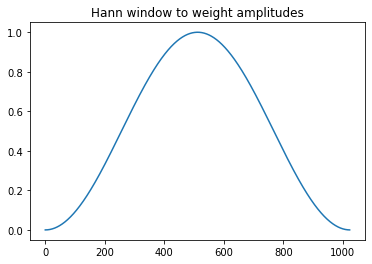

In [246]:
plt.figure(figsize=(6, 4))
plt.title('Hann window to weight amplitudes')
plt.plot(amplitudes_weights)
plt.show()

In [248]:
weighted_dummy_frames = dummy_frames * amplitudes_weights

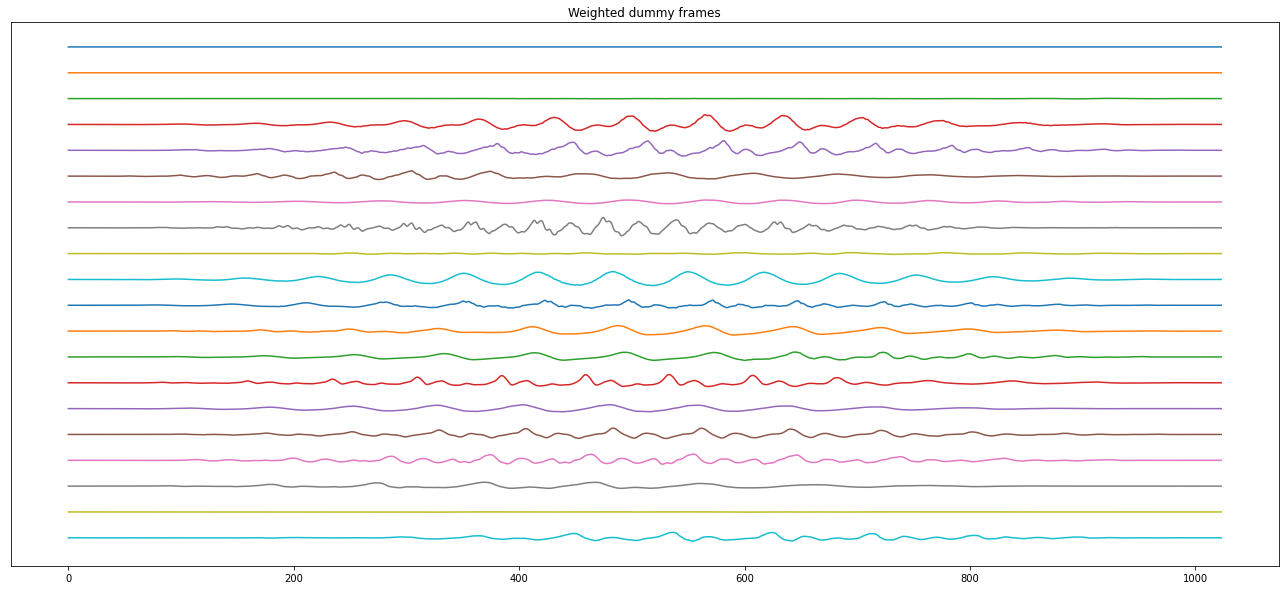

In [251]:
plt.figure(figsize=(50, 10))
plt.subplot(122, title=f'Weighted dummy frames', yticks=[])
for frame_idx, frame in enumerate(weighted_dummy_frames[5:25]):
    plt.plot(frame + 10 - frame_idx)
plt.show()

In [255]:
ft_result = torch.fft.rfft(weighted_dummy_frames)

In [282]:
spectrogram = torch.log(torch.abs(ft_result)**2)

<Figure size 720x576 with 0 Axes>

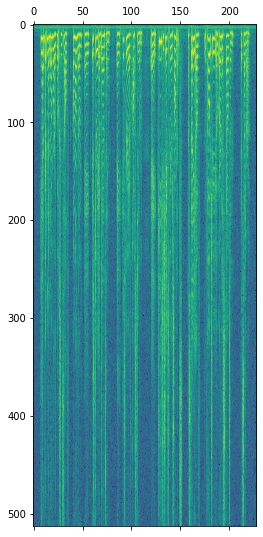

In [283]:
plt.figure(figsize=(10, 8))
plt.matshow(spectrogram.T)
plt.show()